In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse
import pandas as pd
from progressbar import ProgressBar
import scipy

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Reshape, Flatten, GlobalMaxPooling1D, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.initializers import glorot_normal
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse

plt.rcParams.update({'font.size': 18})

In [2]:
def math_fun(x):
    x1=x[:,0]
    x2=x[:,1]
    g=((1.5+x1)**2+4)*(1.5+x2)/20-np.sin(5*(1.5+x1)/2)
    return g

### Prepare the training, testing and OOD data for the ML model
def make_data():
    mean_c1 = (8, 3.5)
    cov_c1 = [[0.4, -0.32], [-0.32, 0.4]]
    c1_sample_no = 500
    x_c1 = np.random.multivariate_normal(mean_c1, cov_c1, (c1_sample_no, 1)).reshape(c1_sample_no, 2)

    mean_c2 = (-2.5, -2.5)
    cov_c2 = [[0.4, -0.32], [-0.32, 0.4]]
    c2_sample_no = 500
    x_c2 = np.random.multivariate_normal(mean_c2, cov_c2, (c2_sample_no, 1)).reshape(c2_sample_no, 2)

    mean_ood = (-10, -7.5)
    cov_ood = [[0.2, -0.16], [-0.16, 0.2]]
    ood_sample_no = 200
    x_ood = np.random.multivariate_normal(mean_ood, cov_ood, (ood_sample_no, 1)).reshape(ood_sample_no, 2) 

    y_c1 = math_fun(x_c1).reshape(-1, 1)
    y_c2 = math_fun(x_c2).reshape(-1, 1)
    y_ood = math_fun(x_ood).reshape(-1, 1)

    ## Create train and test data for each cluster of data
    random_state = 1
    x_c1_train, x_c1_test, y_c1_train, y_c1_test = train_test_split(x_c1, y_c1, test_size=0.2, random_state=random_state)
    x_c2_train, x_c2_test, y_c2_train, y_c2_test = train_test_split(x_c2, y_c2, test_size=0.2, random_state=random_state)

    x_train = np.concatenate((x_c1_train, x_c2_train), axis = 0)
    x_test = np.concatenate((x_c1_test, x_c2_test), axis = 0)
    y_train = np.concatenate((y_c1_train, y_c2_train), axis = 0)
    y_test = np.concatenate((y_c1_test, y_c2_test), axis = 0)

    plt.figure(figsize=(10, 10))
    plt.scatter(x_c1_train[:, 0], x_c1_train[:, 1], color = 'red', marker = '+', label='1st cluster train')
    plt.scatter(x_c1_test[:, 0], x_c1_test[:, 1], color = 'red', marker = 's', label='1st cluster test')

    plt.scatter(x_c2_train[:, 0], x_c2_train[:, 1], color = 'blue', marker = '+', label='2nd cluster train')
    plt.scatter(x_c2_test[:, 0], x_c2_test[:, 1], color = 'blue', marker = 's', label='2nd cluster test')

    plt.scatter(x_ood[:, 0], x_ood[:, 1], color = 'purple', label = 'OOD samples')

    plt.xlabel('X1', fontsize=22, fontweight='bold')
    plt.ylabel('X2', fontsize=22, fontweight='bold')
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18, fontweight='bold')

    plt.legend(fontsize=20)
    plt.axis('equal')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.tight_layout()
    plt.savefig('train_test_data.pdf')

    n_meshes = 200
    x1, x2 = np.meshgrid(np.linspace(-15, 15, n_meshes), np.linspace(-15, 15, n_meshes))
    x_mesh = np.concatenate((x1.reshape(-1, 1), x2.reshape(-1, 1)), axis = 1)
    y_mesh = math_fun(x_mesh).reshape(-1, 1).flatten()

    return x_train, x_test, y_train, y_test, x_ood, y_ood, x_mesh, y_mesh

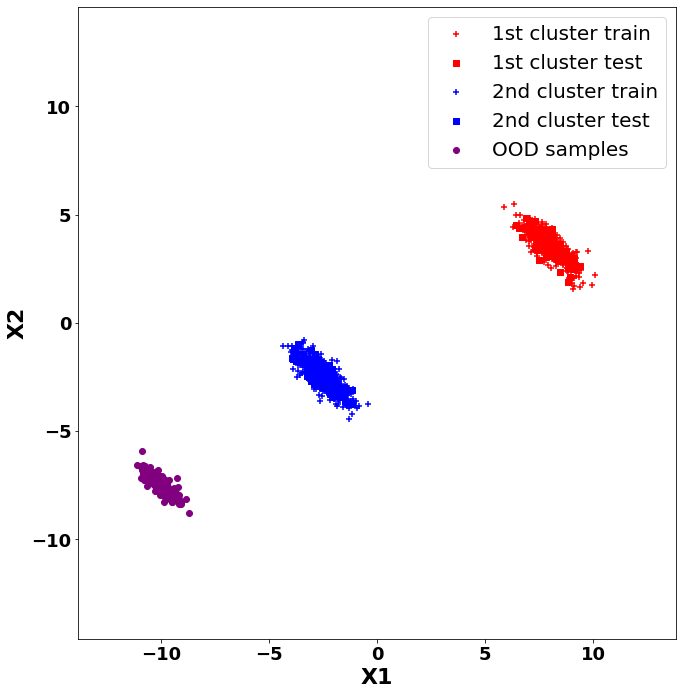

In [3]:
np.random.seed(1)
x_train, x_test, y_train, y_test, x_ood, y_ood, x_mesh, y_mesh = make_data()

In [4]:
scalerX, scalerY = MinMaxScaler(), MinMaxScaler()
x_train_norm, y_train_norm = scalerX.fit_transform(x_train), scalerY.fit_transform(y_train)
x_test_norm, y_test_norm = scalerX.transform(x_test), scalerY.transform(y_test)
x_ood_norm, y_ood_norm   = scalerX.transform(x_ood), scalerY.transform(y_ood)
x_mesh_norm = scalerX.transform(x_mesh)
y_mesh_norm = scalerY.transform(y_mesh.reshape(-1, 1))

In [5]:
def plot_uncertainty_map(x_train, x_ood, x_mesh, output_std, filename, spectral_normalization = False, contour=False):
    std_scaled = output_std/max(output_std)

    plt.figure(figsize=(10, 10))
    plt.rcParams['axes.xmargin'] = 0
    plt.rcParams['axes.ymargin'] = 0
    plt.scatter(x_mesh[:, 0], x_mesh[:, 1], rasterized = True, c = std_scaled, cmap = plt.get_cmap('viridis'))
    
    if spectral_normalization:
        cbar = plt.colorbar(fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=28)
        
    plt.scatter(x_train[:, 0], x_train[:, 1], color = 'magenta', s = 20, alpha = 0.7, label = 'Training')
    plt.scatter(x_ood[:, 0], x_ood[:, 1], color = 'red', s = 20, alpha = 0.7, label = 'OOD')

    if contour:
        n = np.ceil(np.sqrt(len(std_scaled))).astype(int)
        h = std_scaled.reshape(n, n)
        contours = plt.contour(x_mesh[:, 0].reshape(n, n), x_mesh[:, 1].reshape(n, n), h)
        plt.clabel(contours, inline=True, fontsize=12)

        filename += '_with_contour'

    plt.legend(fontsize=20, loc=4)
    plt.xlabel(r'$x_1$', fontsize=40, fontweight='bold')
    plt.ylabel(r'$x_2$', fontsize=40, fontweight='bold')
    plt.xticks(fontsize=36, fontweight='bold')
    plt.yticks(fontsize=36, fontweight='bold')

    plt.tight_layout()
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.savefig(filename+'.pdf')

## Gaussian Process Regression

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

model_GP = GaussianProcessRegressor(kernel=1 * RBF(length_scale=0.001, length_scale_bounds=(1e-3, 1e2)), 
                                    n_restarts_optimizer=10)
model_GP.fit(x_train_norm, y_train_norm)
#  For nu=inf, the kernel becomes equivalent to the RBF kernel and for nu=0.5 to the absolute exponential kernel. 
#  Important intermediate values are nu=1.5 (once differentiable functions) and 
#  nu=2.5 (twice differentiable functions).

C:\Users\Dell\AppData\Roaming\Python\Python39\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=0.001),
                         n_restarts_optimizer=10)

train error (RMSE): 284.0198841136143


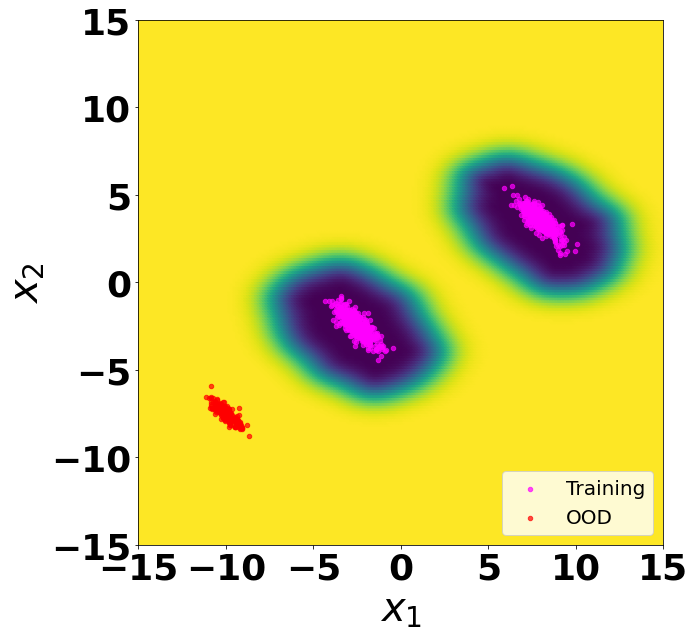

In [7]:
print('train error (RMSE):',  rmse(y_train, model_GP.predict(x_train, return_std=False)))
output, output_std = model_GP.predict(x_mesh_norm, return_std=True)
plot_uncertainty_map(x_train, x_ood, x_mesh, output_std, 'GP', False, False)

In [8]:
def get_confidence_interval(y_true, mu, sigma):  # from Venkat
    alphas = np.linspace(1e-10, 1-1e-10, 1000)
    myCI=[]
    for myalpha in sorted(alphas):
        intervals = scipy.stats.norm.interval(alpha=myalpha, loc=mu, scale=sigma)
        lower_bd = intervals[0]
        upper_bd = intervals[1]
        myCI.append(np.sum((y_true > lower_bd) & (y_true < upper_bd))/len(y_true))
    
    return 100*alphas, 100*np.array(myCI)  # converting to percentages

def calculate_calibration(mean, std, y_ground_truth): # from Xiaoge
    if y_ground_truth.ndim > 1:
        y_ground_truth = y_ground_truth.flatten()

    expected_confidences = np.linspace(0, 1, num = 1000)

    observed_confidences = []
    for expected_confidence in expected_confidences:
        intervals = scipy.stats.norm.interval(expected_confidence, loc=mean, scale=std)
        lb, ub = intervals[0], intervals[1]
        lb_ind = 1*(y_ground_truth >= lb)
        ub_ind = 1*(y_ground_truth <= ub)

        indicator = lb_ind * ub_ind
        observed_confidences.append(sum(indicator)/len(y_ground_truth))

    return 100*np.array(expected_confidences), 100*np.array(observed_confidences)

(0.0, 101.0)

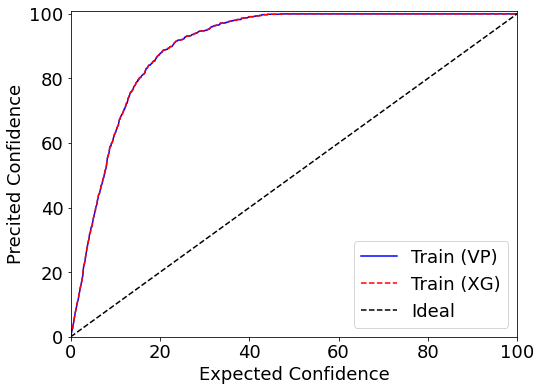

In [9]:
output_mu_train1, output_std_train1 = model_GP.predict(x_train_norm, return_std=True)
expected_CI, observed_CI = get_confidence_interval(y_train_norm.flatten(),
                                        output_mu_train1.flatten(), 
                                        output_std_train1.flatten())

expected_confidences, observed_confidences = calculate_calibration(output_mu_train1.flatten(),
                                                                   output_std_train1.flatten(), 
                                                                   y_train_norm.flatten())


fig = plt.figure(figsize=(8,6))
plt.plot(expected_CI,observed_CI, color = 'blue', label='Train (VP)')
plt.plot(expected_confidences,observed_confidences, color = 'red', label='Train (XG)', linestyle='dashed')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()
plt.ylim([0,101])

(0.0, 101.0)

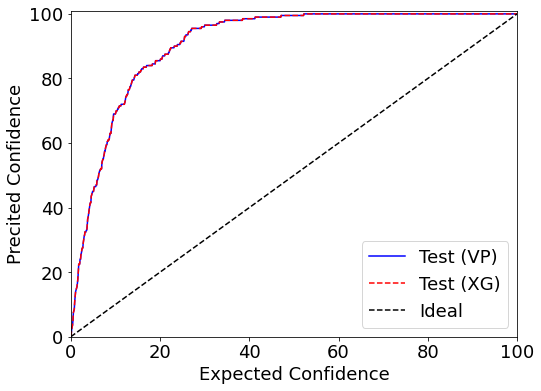

In [10]:
output_mu_test1, output_std_test1 = model_GP.predict(x_test_norm, return_std=True)
expected_CI, observed_CI = get_confidence_interval(y_test_norm.flatten(),
                                        output_mu_test1.flatten(), 
                                        output_std_test1.flatten())

expected_confidences, observed_confidences = calculate_calibration(output_mu_test1.flatten(),
                                                                   output_std_test1.flatten(), 
                                                                   y_test_norm.flatten())


fig = plt.figure(figsize=(8,6))
plt.plot(expected_CI,observed_CI, color = 'blue', label='Test (VP)')
plt.plot(expected_confidences,observed_confidences, color = 'red', label='Test (XG)', linestyle='dashed')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()
plt.ylim([0,101])

(0.0, 101.0)

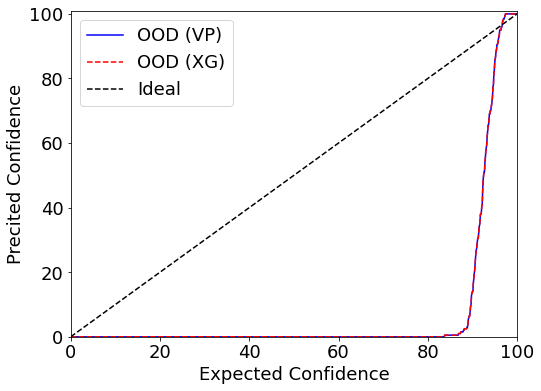

In [11]:
output_mu_ood1, output_std_ood1 = model_GP.predict(x_ood_norm, return_std=True)
expected_CI, observed_CI = get_confidence_interval(y_ood_norm.flatten(),
                                        output_mu_ood1.flatten(), 
                                        output_std_ood1.flatten())

expected_confidences, observed_confidences = calculate_calibration(output_mu_ood1.flatten(),
                                                                   output_std_ood1.flatten(), 
                                                                   y_ood_norm.flatten())


fig = plt.figure(figsize=(8,6))
plt.plot(expected_CI,observed_CI, color = 'blue', label='OOD (VP)')
plt.plot(expected_confidences,observed_confidences, color = 'red', label='OOD (XG)', linestyle='dashed')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()
plt.ylim([0,101])

## MC Dropout - Residual Networks

In [12]:
class DeepResNet(tf.keras.Model):
    """Defines a multi-layer residual network."""
    def __init__(self, num_classes, num_layers=3, num_hidden=128, dropout_rate=0.2):
        super().__init__()
        # Defines class meta data.
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        # Defines the hidden layers.
        self.input_layer = tf.keras.layers.Dense(self.num_hidden, activation = 'relu', trainable=False)
        
        self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

        # Defines the output layer.
        self.regressor = self.make_output_layer(num_classes)

    def call(self, inputs):
        # Projects the 2d input data to high dimension.
        hidden = self.input_layer(inputs)

        # Computes the ResNet hidden representations.
        for i in range(self.num_layers):
            resid = self.dense_layers[i](hidden)
            resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
            hidden += resid

        return self.regressor(hidden)

    def make_dense_layer(self):
        """Uses the Dense layer as the hidden layer."""
        return tf.keras.layers.Dense(self.num_hidden, activation="relu", 
                                     kernel_initializer = tf.keras.initializers.glorot_normal())

    def make_output_layer(self, num_classes):
        """Uses the Dense layer as the output layer."""
        return tf.keras.layers.Dense(num_classes, activation=None)

Model: "deep_res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  150       
                                                                 
 dense_1 (Dense)             multiple                  2550      
                                                                 
 dense_2 (Dense)             multiple                  51        
                                                                 
Total params: 2,751
Trainable params: 2,601
Non-trainable params: 150
_________________________________________________________________


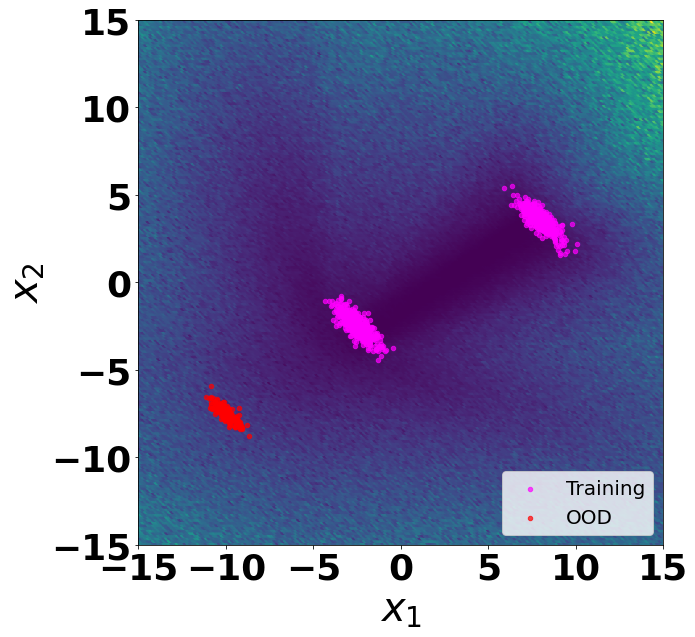

In [13]:
resnet_config = dict(num_classes=1, num_layers=1, num_hidden=50)
resnet_model = DeepResNet(**resnet_config)
resnet_model.build((None, 2))
resnet_model.summary()
optimizer = tf.keras.optimizers.Adam()
train_config = dict(loss='mean_squared_error', optimizer=optimizer)
resnet_model.compile(**train_config)

fit_config = dict(batch_size=128, epochs=800, verbose = 0)
history = resnet_model.fit(x_train_norm, y_train_norm, **fit_config)

niter = 20
MC_output = np.zeros((len(x_mesh),niter))
x_mesh_norm = scalerX.transform(x_mesh)

for i in range(niter):
    MC_output[:,i] = scalerY.inverse_transform(K.get_value(resnet_model(x_mesh_norm, training=True)))[:,0]

plot_uncertainty_map(x_train, x_ood, x_mesh, np.std(MC_output, axis = 1), 'MC1', False, False)

Model: "deep_res_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             multiple                  150       
                                                                 
 dense_4 (Dense)             multiple                  2550      
                                                                 
 dense_5 (Dense)             multiple                  2550      
                                                                 
 dense_6 (Dense)             multiple                  2550      
                                                                 
 dense_7 (Dense)             multiple                  51        
                                                                 
Total params: 7,851
Trainable params: 7,701
Non-trainable params: 150
_________________________________________________________________


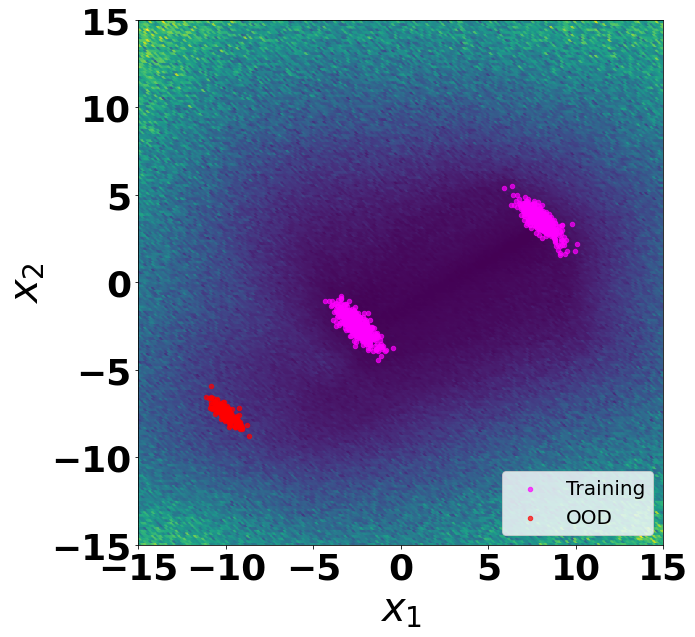

In [14]:
resnet_config = dict(num_classes=1, num_layers=3, num_hidden=50)
resnet_model = DeepResNet(**resnet_config)
resnet_model.build((None, 2))
resnet_model.summary()
optimizer = tf.keras.optimizers.Adam()
train_config = dict(loss='mean_squared_error', optimizer=optimizer)
resnet_model.compile(**train_config)

fit_config = dict(batch_size=128, epochs=1000, verbose = 0)
history = resnet_model.fit(x_train_norm, y_train_norm, **fit_config)

niter = 20
MC_output = np.zeros((len(x_mesh),niter))
x_mesh_norm = scalerX.transform(x_mesh)

for i in range(niter):
    MC_output[:,i] = scalerY.inverse_transform(K.get_value(resnet_model(x_mesh_norm, training=True)))[:,0]

plot_uncertainty_map(x_train, x_ood, x_mesh, np.std(MC_output, axis = 1), 'MC2', False, False)

Model: "deep_res_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             multiple                  150       
                                                                 
 dense_9 (Dense)             multiple                  2550      
                                                                 
 dense_10 (Dense)            multiple                  2550      
                                                                 
 dense_11 (Dense)            multiple                  2550      
                                                                 
 dense_12 (Dense)            multiple                  2550      
                                                                 
 dense_13 (Dense)            multiple                  2550      
                                                                 
 dense_14 (Dense)            multiple               

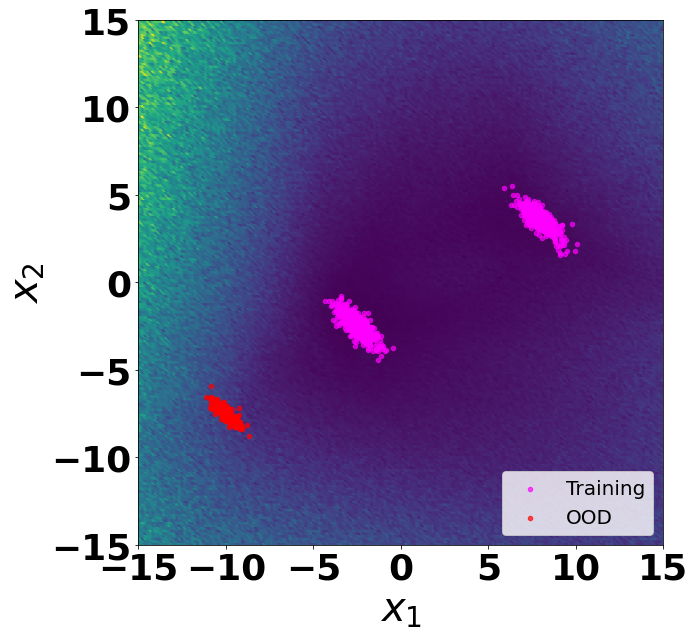

In [15]:
resnet_config = dict(num_classes=1, num_layers=5, num_hidden=50)
resnet_model = DeepResNet(**resnet_config)
resnet_model.build((None, 2))
resnet_model.summary()
optimizer = tf.keras.optimizers.Adam()
train_config = dict(loss='mean_squared_error', optimizer=optimizer)
resnet_model.compile(**train_config)

fit_config = dict(batch_size=128, epochs=1000, verbose = 0)
history = resnet_model.fit(x_train_norm, y_train_norm, **fit_config)

niter = 20
MC_output = np.zeros((len(x_mesh),niter))
x_mesh_norm = scalerX.transform(x_mesh)

for i in range(niter):
    MC_output[:,i] = scalerY.inverse_transform(K.get_value(resnet_model(x_mesh_norm, training=True)))[:,0]

plot_uncertainty_map(x_train, x_ood, x_mesh, np.std(MC_output, axis = 1), 'MC3', False, False)

Model: "deep_res_net_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            multiple                  300       
                                                                 
 dense_16 (Dense)            multiple                  10100     
                                                                 
 dense_17 (Dense)            multiple                  10100     
                                                                 
 dense_18 (Dense)            multiple                  10100     
                                                                 
 dense_19 (Dense)            multiple                  10100     
                                                                 
 dense_20 (Dense)            multiple                  10100     
                                                                 
 dense_21 (Dense)            multiple               

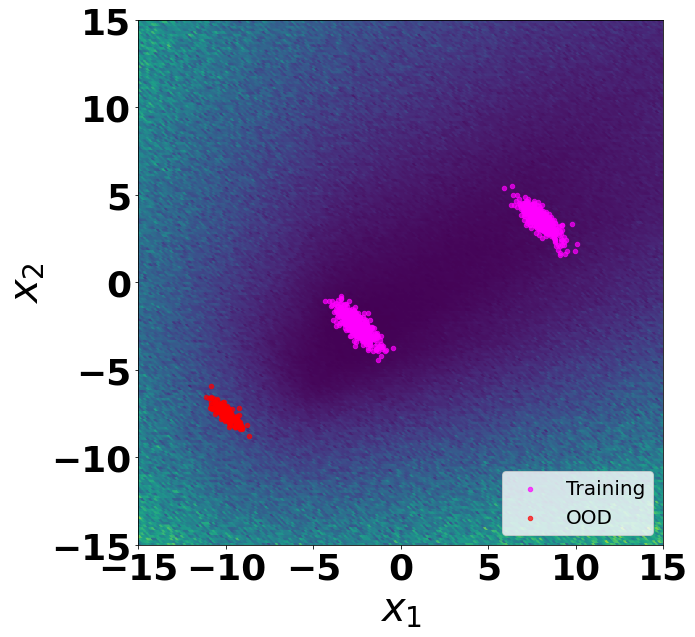

In [16]:
resnet_config = dict(num_classes=1, num_layers=10, num_hidden=100)
resnet_model = DeepResNet(**resnet_config)
resnet_model.build((None, 2))
resnet_model.summary()
optimizer = tf.keras.optimizers.Adam()
train_config = dict(loss='mean_squared_error', optimizer=optimizer)
resnet_model.compile(**train_config)

fit_config = dict(batch_size=128, epochs=500, verbose = 0)
history = resnet_model.fit(x_train_norm, y_train_norm, **fit_config)

niter = 20
MC_output = np.zeros((len(x_mesh),niter))
x_mesh_norm = scalerX.transform(x_mesh)

for i in range(niter):
    MC_output[:,i] = scalerY.inverse_transform(K.get_value(resnet_model(x_mesh_norm, training=True)))[:,0]

plot_uncertainty_map(x_train, x_ood, x_mesh, np.std(MC_output, axis = 1), 'MC4', False, False)

In [17]:
# def generate_trained_MCmodel(trainX, trainY, nepochs, actfn = 'sigmoid'):
#     n_inp_features = np.shape(trainX)[1]
#     feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
#     x = Dense(10, activation = actfn)(feature_input)
#     x = Dropout(rate = 0.20)(x)
#     mu = Dense(1, activation = actfn)(x)

#     model = Model(feature_input, mu)
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)

#     return model
# model_MC = generate_trained_MCmodel(x_train_norm, y_train_norm, 300, 'tanh')
# niter = 20
# MC_output = np.zeros((len(x_mesh),niter))
# x_mesh_norm = scalerX.transform(x_mesh)

# for i in range(niter):
#     MC_output[:,i] = scalerY.inverse_transform(K.get_value(model_MC(x_mesh_norm, training=True)))[:,0]
    
# plot_uncertainty_map(x_mesh, np.std(MC_output, axis = 1), False, False, 'MC')

## Deep Ensemble

In [18]:
# loss function and new custom layer to give mean and standard deviation
# Inspired from https://medium.com/@albertoarrigoni/paper-review-code-deep-ensembles-nips-2017-c5859070b8ce
def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.math.log((sigma)) + 0.5*tf.math.divide(tf.math.square(y_true - y_pred), (sigma))) + 1e-6
    return gaussian_loss
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [19]:
def generate_trained_DEmodel(num_hidden, num_layers, trainX, trainY, nepochs, actfn = 'sigmoid'):
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(num_hidden, activation = actfn)(feature_input)
    for _ in range(num_layers):
        x = Dense(num_hidden, activation = actfn)(x)
        x1 = Dense(num_hidden, activation = actfn)(x)
        x = x1 + x
    x = Dense(10, activation = actfn)(x)
    mu, sigma = GaussianLayer(1, name='main_output')(x)
    model = Model(feature_input, mu)
    model.compile(loss=custom_loss(sigma), optimizer='adam')
    history = model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)
    
    layer_name = 'main_output' # Where to extract the Gaussian output from. 
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)
    return get_intermediate

def get_ensemble(df, UQmodelcode, nmodels_select):
    mu_cols = [UQmodelcode + "_mu_"+str(i) for i in range(nmodels_select)]
    sigma_cols = [UQmodelcode + "_sigma_"+str(i) for i in range(nmodels_select)]
    
    mu_eff = df[mu_cols].mean(axis=1)
    sigma_eff =  np.sqrt(np.mean(df[mu_cols]**2, axis = 1)
                         + np.mean(df[sigma_cols]**2, axis = 1)
                         - mu_eff**2)
    df[UQmodelcode+"_mu_eff"] = mu_eff
    df[UQmodelcode+"_sigma_eff"] = sigma_eff
    return df

100% |########################################################################|


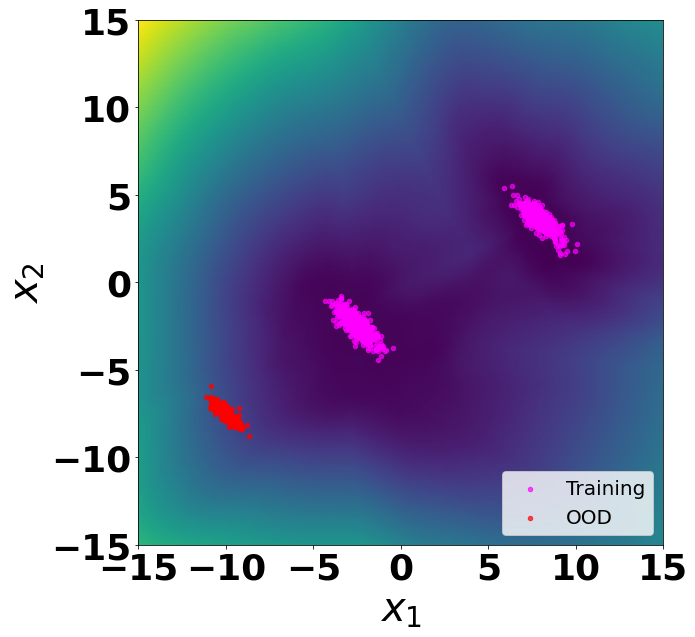

In [20]:
## Create 10 models and select some based on training error
prediction_fns, train_rmse = [], []
nmodels = 10
nepochs = 1000
num_hidden = 20
num_layers = 3

pbar=ProgressBar()
for i in pbar(range(nmodels)):
    my_func = generate_trained_DEmodel(num_hidden, num_layers, x_train_norm, y_train_norm, 
                                       nepochs, actfn = 'relu')
    train_rmse.append(rmse(y_train, scalerY.inverse_transform(my_func(x_train_norm)[0])))
    prediction_fns.append(my_func)

# Select models based on training RMSE
nmodels_select = nmodels  # using all trained models
final_DE_fns = []
for i in range(nmodels_select):
    final_DE_fns.append(prediction_fns[np.argsort(train_rmse)[:nmodels_select][i]])
    
    
result_df = pd.DataFrame(x_mesh, columns = ['x1', 'x2'])
for i in range(nmodels_select):
    result_df["DE_mu_"+str(i)] = scalerY.inverse_transform(final_DE_fns[i](x_mesh_norm)[0])
    result_df["DE_sigma_"+str(i)] = scalerY.inverse_transform(np.sqrt(final_DE_fns[i](x_mesh_norm)[1]))

result_df = get_ensemble(result_df, "DE", nmodels_select)
plot_uncertainty_map(x_train, x_ood, x_mesh, result_df['DE_sigma_eff'], 'DE_1', False, False)

100% |########################################################################|


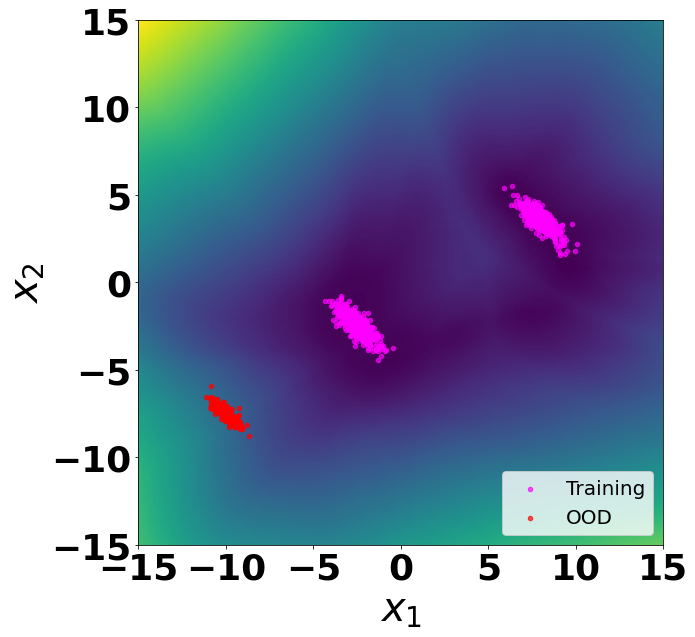

In [21]:
## Create 10 models and select some based on training error
prediction_fns, train_rmse = [], []
nmodels = 10
nepochs = 200
num_hidden = 20
num_layers = 3

pbar=ProgressBar()
for i in pbar(range(nmodels)):
    my_func = generate_trained_DEmodel(num_hidden, num_layers, x_train_norm, y_train_norm, 
                                       nepochs, actfn = 'relu')
    train_rmse.append(rmse(y_train, scalerY.inverse_transform(my_func(x_train_norm)[0])))
    prediction_fns.append(my_func)

# Select models based on training RMSE
nmodels_select = nmodels  # using all trained models
final_DE_fns = []
for i in range(nmodels_select):
    final_DE_fns.append(prediction_fns[np.argsort(train_rmse)[:nmodels_select][i]])
    
    
result_df = pd.DataFrame(x_mesh, columns = ['x1', 'x2'])
for i in range(nmodels_select):
    result_df["DE_mu_"+str(i)] = scalerY.inverse_transform(final_DE_fns[i](x_mesh_norm)[0])
    result_df["DE_sigma_"+str(i)] = scalerY.inverse_transform(np.sqrt(final_DE_fns[i](x_mesh_norm)[1]))

result_df = get_ensemble(result_df, "DE", nmodels_select)
plot_uncertainty_map(x_train, x_ood, x_mesh, result_df['DE_sigma_eff'], 'DE_2', False, False)

100% |########################################################################|


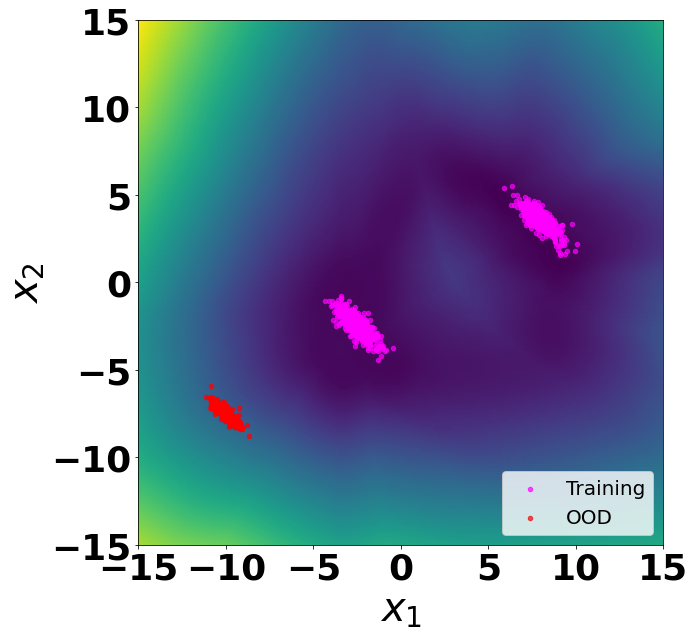

In [22]:
## Create 10 models and select some based on training error
prediction_fns, train_rmse = [], []
nmodels = 10
nepochs = 200
num_hidden = 50
num_layers = 3

pbar=ProgressBar()
for i in pbar(range(nmodels)):
    my_func = generate_trained_DEmodel(num_hidden, num_layers, x_train_norm, y_train_norm, 
                                       nepochs, actfn = 'relu')
    train_rmse.append(rmse(y_train, scalerY.inverse_transform(my_func(x_train_norm)[0])))
    prediction_fns.append(my_func)

# Select models based on training RMSE
nmodels_select = nmodels  # using all trained models
final_DE_fns = []
for i in range(nmodels_select):
    final_DE_fns.append(prediction_fns[np.argsort(train_rmse)[:nmodels_select][i]])
    
    
result_df = pd.DataFrame(x_mesh, columns = ['x1', 'x2'])
for i in range(nmodels_select):
    result_df["DE_mu_"+str(i)] = scalerY.inverse_transform(final_DE_fns[i](x_mesh_norm)[0])
    result_df["DE_sigma_"+str(i)] = scalerY.inverse_transform(np.sqrt(final_DE_fns[i](x_mesh_norm)[1]))

result_df = get_ensemble(result_df, "DE", nmodels_select)
plot_uncertainty_map(x_train, x_ood, x_mesh, result_df['DE_sigma_eff'], 'DE_3', False, False)